In [1]:
import numpy as np
import joblib
import shutil
import pandas as pd
from sklearn import metrics
import re
from matplotlib import pyplot as plt
import os
import dendropy
import itertools
import importlib
import seaborn as sns
import time
import gc
from tqdm import tqdm
import json
import time
import itertools
# from Bio import SeqIO
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from joblib import Parallel, delayed
import pickle
import joblib
import gc
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn

TypeError: unhashable type: 'list'

In [31]:
# load data
# quartet net
df_iq_net_top = pd.read_csv('./data/iq_net_top_df.csv')
df_iq_net_bls = pd.read_csv('./data/iq_net_bls_df.csv')

# test data, ground truth for iq_net
df_test = pd.read_csv('./data/data_test.csv')

# iq tree and other benchmarkning data, contains predicted top/ bls, and ground truth
df_iqtree = pd.read_csv('./data/test_data_iq_tree_sorted.csv')
df_fusang = pd.read_csv('./data/test_data_fusang.csv')
df_deepnn = pd.read_csv('./data/DeepNN_test.csv')
# df_suvorov = pd.read_csv('./IQ_Net/data/Suvorov_test_nogap.csv')

# df_val_sort = pd.read_csv('./My_model/data/data_unshuffle_test_v3.csv')



In [32]:
# compute adaptive sequence length
df_test['adapt_seq_length'] = (1-df_test['----']) * df_test['seq_length']



# insert adaptive sequence length to df
df_iq_net_top = df_iq_net_top.merge(df_test[['tree_id', 'adapt_seq_length']], on='tree_id', how='right')
df_iq_net_bls = df_iq_net_bls.merge(df_test[['tree_id', 'adapt_seq_length']], on='tree_id', how='right')

df_iqtree = df_iqtree.merge(df_test[['tree_id', 'adapt_seq_length']], on='tree_id', how='right')
df_fusang = df_fusang.merge(df_test[['tree_id', 'adapt_seq_length']], on='tree_id', how='right')

df_deepnn = df_deepnn.merge(df_test[['tree_id', 'adapt_seq_length', 'top','int_b','seq_length']], on='tree_id', how='right')

df_suvorov = pd.merge(df_test, df_suvorov, on='tree_id', how='inner')
# df_suvorov = df_suvorov.merge(df_test[['tree_id', 'adapt_seq_length','top','int_b','seq_length']], on='tree_id', how='right')

In [33]:
# insrt true and pred topology to bls df
df_iq_net_bls = df_quartet_net_bls.merge(df_quartet_net_top[['tree_id', 'pred_top','top']], on='tree_id', how='right')

In [34]:
def branch_score_distance(row):
    if row['top'] == row['pred_top']:
        return abs(row['pred_int_b'] - row['int_b'])
    else:
        return np.sqrt(row['pred_int_b']**2 + row['int_b']**2)

In [35]:
df_quartet_net_bls['bsd'] = df_quartet_net_bls.apply(branch_score_distance, axis=1)
df_iqtree['bsd'] = df_iqtree.apply(branch_score_distance, axis=1)

In [31]:
# compute branch score distance
print(df_quartet_net_bls['bsd'].mean())

0.03182043291815822


In [32]:
print(df_iqtree['bsd'].mean())

0.03833762580444057


In [9]:
def adaptive_histogram(data, bins):
    """
    creative adaptive histogram to make each bin contians the same number of data points
    
    input:
        data (array-like): input array
        bins (int): bumber of bins
    
    return:
        hist (array): bin count
        bin_edges (array): bin edge
    """
    # sort the data
    sorted_data = np.sort(data)
    # find the dege
    bin_edges = np.interp(
        np.linspace(0, len(sorted_data), bins + 1),  
        np.arange(len(sorted_data)),  
        sorted_data                  
    )
    hist, bin_edges = np.histogram(data, bins=bin_edges)
    return hist, bin_edges



In [14]:
# compute overall accuracy
print('deepnn')
print((df_deepnn['top'] == df_deepnn['pred_top']).sum()/df_deepnn.shape[0])

deepnn
0.7858017135862914


In [46]:
# print('suvorov')
# print((df_suvorov['top'] == df_suvorov['pred_top']).sum()/df_suvorov.shape[0])

suvorov
0.3242438436830835


In [91]:
print('fusang')
print((df_fusang['top'] == df_fusang['pred_top']).sum()/df_fusang.shape[0])

fusang
0.7487858806806965


In [16]:
# overall accuracy of iq-tree
print('iq-tree')
print((df_iqtree['top'] == df_iqtree['pred_top']).sum()/df_iqtree.shape[0])

iq-tree
0.7982587752201208


In [30]:
# overall accuracy of iq_net
print('my model')
print((df_iq_net_top['pred_top'] == df_iq_net_top['top']).sum()/df_iq_net_top.shape[0])

my model
0.8197378291941406


C:\Users\cheny\AppData\Local\Temp\ipykernel_22000\2334820575.py:23: RuntimeWarning: divide by zero encountered in log10
  bins = np.array([10**((np.log10(edges[b]) + np.log10(edges[b+1]))/2)for b in range(len(edges) -1)])
C:\Users\cheny\AppData\Local\Temp\ipykernel_22000\2334820575.py:33: RuntimeWarning: divide by zero encountered in log10
  bins = np.array([10**((np.log10(edges[b]) + np.log10(edges[b+1]))/2)for b in range(len(edges) -1)])
C:\Users\cheny\AppData\Local\Temp\ipykernel_22000\2334820575.py:42: RuntimeWarning: divide by zero encountered in log10
  bins = np.array([10**((np.log10(edges[b]) + np.log10(edges[b+1]))/2)for b in range(len(edges) -1)])
C:\Users\cheny\AppData\Local\Temp\ipykernel_22000\2334820575.py:51: RuntimeWarning: divide by zero encountered in log10
  bins = np.array([10**((np.log10(edges[b]) + np.log10(edges[b+1]))/2)for b in range(len(edges) -1)])


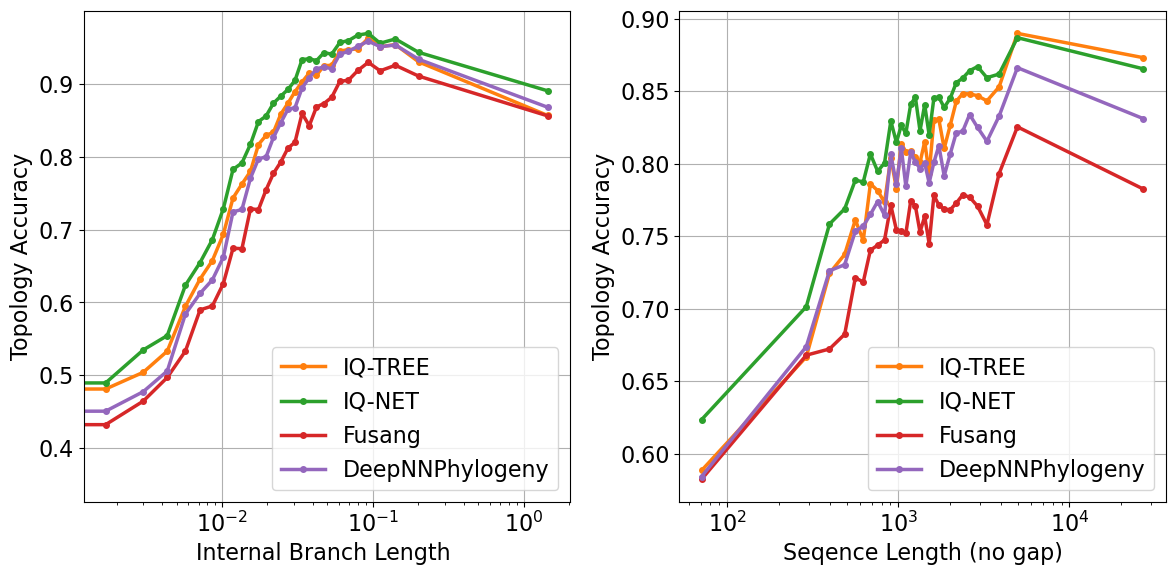

In [36]:
plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = [8,8]
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 3
num_bins = 60
lower= -4
upper = 1
# for poster 
plt.figure(figsize=(12, 6))
# true_df = y_val_reset
# df = model2_pred

_,cusomize_edges = adaptive_histogram(df_test.int_b,30)



plt.subplot(1,2,1)
true_df = df_iqtree[['top','int_b']]
df = df_iqtree[['pred_top','int_b']]
correct_top = true_df['top'] == df['pred_top']
e_hist, edges = np.histogram(true_df.int_b[~correct_top], bins=cusomize_edges )
c_hist, edges = np.histogram(true_df.int_b[correct_top], bins=cusomize_edges )
bins = np.array([10**((np.log10(edges[b]) + np.log10(edges[b+1]))/2)for b in range(len(edges) -1)])
mask = e_hist+c_hist != 0
plt.plot(bins[mask],(c_hist / (c_hist+e_hist))[mask], 'o-',c=plt.cm.tab10(1),markersize=4, linewidth = 2.5,alpha=1,label='IQ-TREE' )


true_df = df_iq_net_top[['top','int_b']]
df = df_iq_net_top[['pred_top','int_b']]
correct_top = true_df['top'] == df['pred_top']
e_hist, edges = np.histogram(true_df.int_b[~correct_top], bins=cusomize_edges )
c_hist, edges = np.histogram(true_df.int_b[correct_top], bins=cusomize_edges )
bins = np.array([10**((np.log10(edges[b]) + np.log10(edges[b+1]))/2)for b in range(len(edges) -1)])
mask = e_hist+c_hist != 0
plt.plot(bins[mask],(c_hist / (c_hist+e_hist))[mask], 'o-',c=plt.cm.tab10(2),markersize=4, linewidth = 2.5,alpha=1,label='IQ-NET' )

true_df = df_fusang[['top','int_b']]
df = df_fusang[['pred_top','int_b']]
correct_top = true_df['top'] == df['pred_top']
e_hist, edges = np.histogram(true_df.int_b[~correct_top], bins=cusomize_edges )
c_hist, edges = np.histogram(true_df.int_b[correct_top], bins=cusomize_edges )
bins = np.array([10**((np.log10(edges[b]) + np.log10(edges[b+1]))/2)for b in range(len(edges) -1)])
mask = e_hist+c_hist != 0
plt.plot(bins[mask],(c_hist / (c_hist+e_hist))[mask], 'o-',c=plt.cm.tab10(3),markersize=4, linewidth = 2.5,alpha=1,label='Fusang' )

true_df = df_deepnn[['top','int_b']]
df = df_deepnn[['pred_top','int_b']]
correct_top = true_df['top'] == df['pred_top']
e_hist, edges = np.histogram(true_df.int_b[~correct_top], bins=cusomize_edges )
c_hist, edges = np.histogram(true_df.int_b[correct_top], bins=cusomize_edges )
bins = np.array([10**((np.log10(edges[b]) + np.log10(edges[b+1]))/2)for b in range(len(edges) -1)])
mask = e_hist+c_hist != 0
plt.plot(bins[mask],(c_hist / (c_hist+e_hist))[mask], 'o-',c=plt.cm.tab10(4),markersize=4, linewidth = 2.5,alpha=1,label='DeepNNPhylogeny' )

plt.xscale('log')
plt.xlabel('Internal Branch Length ')
plt.ylabel('Topology Accuracy')
plt.legend()
plt.grid()


plt.subplot(1,2,2)
_,cusomize_edges = adaptive_histogram(df_test.adapt_seq_length,30)




true_df = df_iqtree[['top','seq_length','int_b','adapt_seq_length']]
df = df_iqtree[['pred_top','int_b']]
correct_top = true_df['top'] == df['pred_top']
e_hist, edges = np.histogram(true_df.adapt_seq_length[~correct_top], bins=cusomize_edges )
c_hist, edges = np.histogram(true_df.adapt_seq_length[correct_top], bins=cusomize_edges )
bins = np.array([10**((np.log10(edges[b]) + np.log10(edges[b+1]))/2)for b in range(len(edges) -1)])
mask = e_hist+c_hist != 0
plt.plot(bins[mask],(c_hist / (c_hist+e_hist))[mask], 'o-',c=plt.cm.tab10(1),markersize=4, linewidth = 2.5,alpha=1,label='IQ-TREE' )


true_df = df_iq_net_top[['top','seq_length','int_b','adapt_seq_length']]
df = df_iq_net_top[['pred_top','int_b']]
correct_top = true_df['top'] == df['pred_top']
e_hist, edges = np.histogram(true_df.adapt_seq_length[~correct_top], bins=cusomize_edges )
c_hist, edges = np.histogram(true_df.adapt_seq_length[correct_top], bins=cusomize_edges )
bins = np.array([10**((np.log10(edges[b]) + np.log10(edges[b+1]))/2)for b in range(len(edges) -1)])
mask = e_hist+c_hist != 0
plt.plot(bins[mask],(c_hist / (c_hist+e_hist))[mask], 'o-',c=plt.cm.tab10(2),markersize=4, linewidth = 2.5,alpha=1,label='IQ-NET' )

true_df = df_fusang[['top','seq_length','int_b','adapt_seq_length']]
df = df_fusang[['pred_top','int_b']]
correct_top = true_df['top'] == df['pred_top']
e_hist, edges = np.histogram(true_df.adapt_seq_length[~correct_top], bins=cusomize_edges )
c_hist, edges = np.histogram(true_df.adapt_seq_length[correct_top], bins=cusomize_edges )
bins = np.array([10**((np.log10(edges[b]) + np.log10(edges[b+1]))/2)for b in range(len(edges) -1)])
mask = e_hist+c_hist != 0
plt.plot(bins[mask],(c_hist / (c_hist+e_hist))[mask], 'o-',c=plt.cm.tab10(3),markersize=4, linewidth = 2.5,alpha=1,label='Fusang' )

true_df = df_deepnn[['top','seq_length','int_b','adapt_seq_length']]
df = df_deepnn[['pred_top','int_b']]
correct_top = true_df['top'] == df['pred_top']
e_hist, edges = np.histogram(true_df.adapt_seq_length[~correct_top], bins=cusomize_edges )
c_hist, edges = np.histogram(true_df.adapt_seq_length[correct_top], bins=cusomize_edges )
bins = np.array([10**((np.log10(edges[b]) + np.log10(edges[b+1]))/2)for b in range(len(edges) -1)])
mask = e_hist+c_hist != 0
plt.plot(bins[mask],(c_hist / (c_hist+e_hist))[mask], 'o-',c=plt.cm.tab10(4),markersize=4, linewidth = 2.5,alpha=1,label='DeepNNPhylogeny' )


plt.xscale('log')
plt.xlabel('Seqence Length (no gap)')
plt.ylabel('Topology Accuracy')
plt.legend()
plt.grid()
plt.tight_layout(pad=1.0)
plt.savefig('compare_val_acc_intl_seq.png',dpi=500,bbox_inches='tight')
plt.show()

In [22]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error,root_mean_squared_error
def relative_difference_mean(a, b):
    EPSILON = 1e-10
    

    result = np.divide(np.abs(a - b), a, out=np.full_like(a, 0), where=a != 0)
    

    return np.mean(result)

def relative_difference(a, b):
    EPSILON = 1e-10
    

    result = np.divide(np.abs(a - b), a, out=np.full_like(a, 0), where=a != 0)
    

    return np.array(result)

target_list = ['ext_b1','ext_b2','ext_b3','ext_b4']
taxa = ['pred_a','pred_b','pred_c','pred_d']

arr_iq_tree = df_iqtree.loc[:,taxa].to_numpy().flatten()
arr_test = df_iqtree.loc[:,target_list].to_numpy().flatten()


# arr_test_iq_net = df_quartet_net_bls.loc[:,target_list].to_numpy().flatten()
arr_iq_net_bls = df_iq_net_bls.loc[:,taxa].to_numpy().flatten()

print('External branch')
print('IQ_Tree:')
print(round(relative_difference_mean(arr_test,arr_iq_tree),4))
print('My Model with gaps:')
print(round(relative_difference_mean(arr_test,arr_iq_net_bls),4))

print('internal branch')
print('IQ_Tree:')
print(round(relative_difference_mean(df_iqtree['int_b'],df_iqtree['pred_int_b']),4))
print('My Model with gaps:')
print(round(relative_difference_mean(df_iq_net_bls['int_b'],df_iq_net_bls['pred_int_b']),4))
print('---------------------------------------')
print('MSE')
print('External branch')
print('IQ_Tree:')
print(round(mean_squared_error(arr_test,arr_iq_tree),4))
print('My Model:')
print(round(mean_squared_error(arr_test,arr_iq_net_bls),4))

print('internal branch')
print('IQ_Tree:')
print(round(mean_squared_error(df_iqtree['int_b'],df_iqtree['pred_int_b']),4))
print('My Model:')
print(round(mean_squared_error(df_iq_net_bls['int_b'],df_iq_net_bls['pred_int_b']),4))
print('---------------------------------------')
print('RMSE')
print('External branch')
print('IQ_Tree:')
print(round(root_mean_squared_error(arr_test,arr_iq_tree),4))
print('My Model:')
print(round(root_mean_squared_error(arr_test,arr_iq_net_bls),4))

print('internal branch')
print('IQ_Tree:')
print(round(root_mean_squared_error(df_iqtree['int_b'],df_iqtree['pred_int_b']),4))
print('My Model:')
print(round(root_mean_squared_error(df_iq_net_bls['int_b'],df_iq_net_bls['pred_int_b']),4))
print('---------------------------------------')
print('MAE')
print('External branch')
print('IQ_Tree:')
print(round(mean_absolute_error(arr_test,arr_iq_tree),4))
print('My Model:')
print(round(mean_absolute_error(arr_test,arr_iq_net_bls),4))

print('internal branch')
print('IQ_Tree:')
print(round(mean_absolute_error(df_iqtree['int_b'],df_iqtree['pred_int_b']),4))
print('My Model:')
print(round(mean_absolute_error(df_iq_net_bls['int_b'],df_iq_net_bls['pred_int_b']),4))
print('---------------------------------------')
print('R2')
print('External branch')
print('IQ_Tree:')
print(round(r2_score(arr_test,arr_iq_tree),4))
print('My Model:')
print(round(r2_score(arr_test,arr_iq_net_bls),4))

print('internal branch')
print('IQ_Tree:')
print(round(r2_score(df_iqtree['int_b'],df_iqtree['pred_int_b']),4))
print('My Model:')
print(round(r2_score(df_iq_net_bls['int_b'],df_iq_net_bls['pred_int_b']),4))

External branch
IQ_Tree:
0.2614
My Model with gaps:


NameError: name 'arr_test_quartet' is not defined

In [239]:
target_list = ['ext_b1','ext_b2','ext_b3','ext_b4','int_b','seq_length']

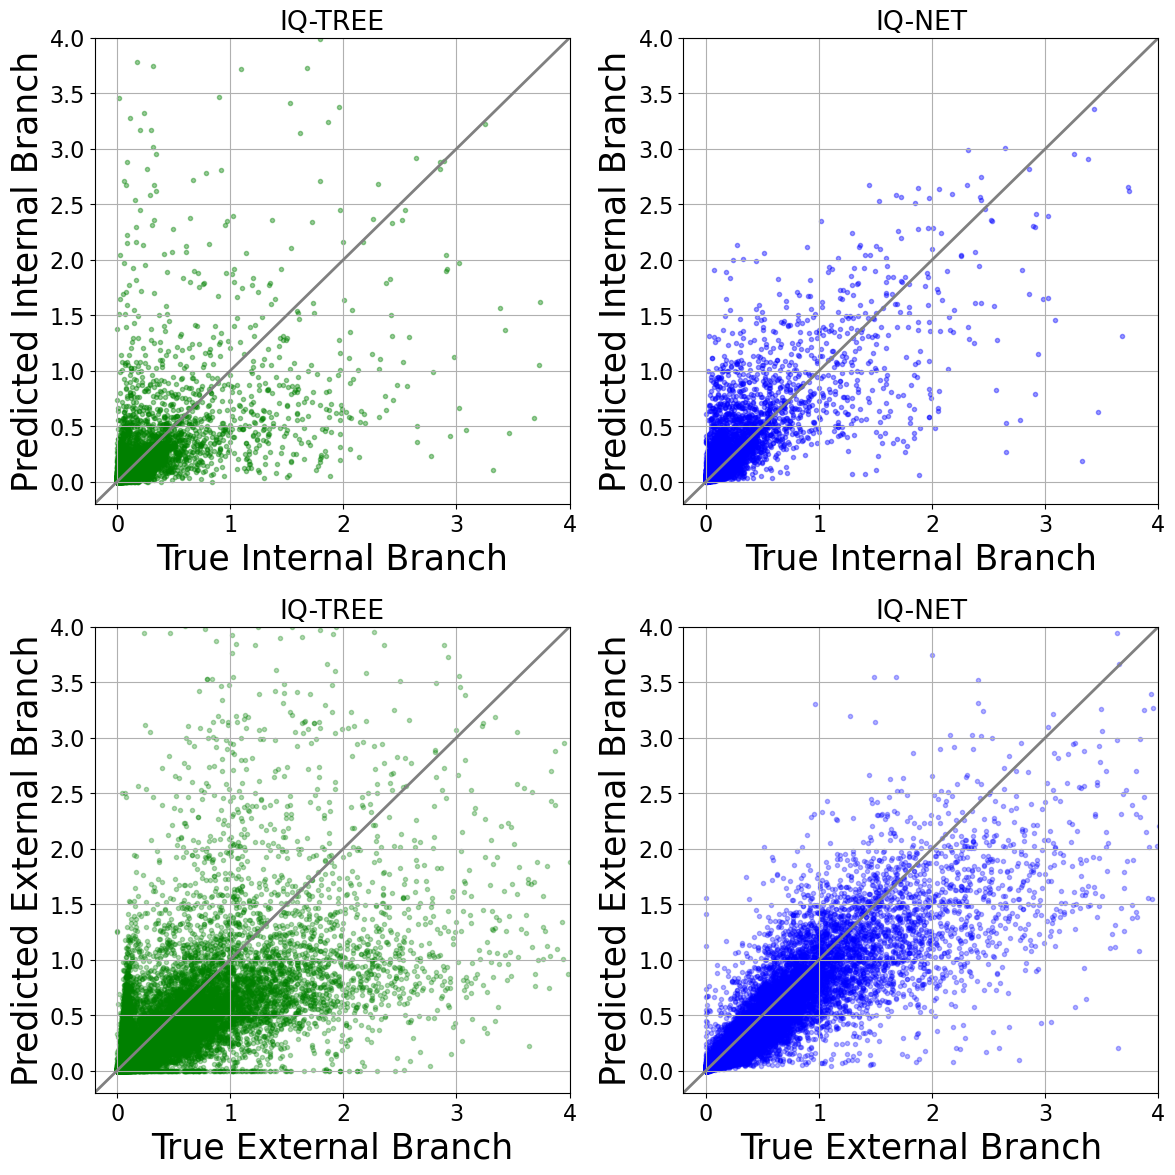

In [11]:
plt.figure(figsize=(12,12))

plt.subplot(2,2,1)
trueb = df_iqtree['int_b']
predb = df_iqtree['pred_int_b']
plt.scatter(trueb, predb ,alpha=0.4, c='green')
plt.plot(np.linspace(-1,8,20),np.linspace(-1,8,20) , color = '0.5')    
plt.xlabel('True Internal Branch',fontsize=25)
plt.ylabel('Predicted Internal Branch',fontsize=25)
plt.xlim(-0.2,4)
plt.ylim(-0.2,4)
plt.title('IQ-TREE')
plt.grid()


plt.subplot(2,2,2)
trueb = arr_iq_net_bls['int_b']
predb = arr_iq_net_bls['pred_int_b']
plt.scatter(trueb, predb,alpha=0.4, c='blue')
plt.plot(np.linspace(-1,8,20),np.linspace(-1,8,20) , color = '0.5')    
plt.xlabel('True Internal Branch',fontsize=25)
plt.ylabel('Predicted Internal Branch',fontsize=25)
plt.xlim(-0.2,4)
plt.ylim(-0.2,4)
plt.title('IQ-NET')
plt.grid()

#-----------------------------------------------------
plt.subplot(2,2,3)
trueb = df_iqtree['ext_b1']
predb = df_iqtree['pred_a']
plt.scatter(trueb, predb ,alpha=0.3, c='green')
trueb = df_iqtree['ext_b2']
predb = df_iqtree['pred_b']
plt.scatter(trueb, predb ,alpha=0.3, c='green')
trueb = df_iqtree['ext_b3']
predb = df_iqtree['pred_c']
plt.scatter(trueb, predb ,alpha=0.3, c='green')
trueb = df_iqtree['ext_b4']
predb = df_iqtree['pred_d']
plt.scatter(trueb, predb ,alpha=0.3, c='green')
plt.plot(np.linspace(-1,8,20),np.linspace(-1,8,20) , color = '0.5')    
plt.xlabel('True External Branch',fontsize=25)
plt.ylabel('Predicted External Branch',fontsize=25)
plt.xlim(-0.2,4)
plt.ylim(-0.2,4)
plt.title('IQ-TREE')
plt.grid()

plt.subplot(2,2,4)
trueb = arr_iq_net_bls['ext_b1']
predb = arr_iq_net_bls['pred_a']
plt.scatter(trueb, predb,alpha=0.3, c='blue')

trueb = arr_iq_net_bls['ext_b2']
predb = arr_iq_net_bls['pred_b']
plt.scatter(trueb, predb,alpha=0.3, c='blue')

trueb = arr_iq_net_bls['ext_b3']
predb = arr_iq_net_bls['pred_c']
plt.scatter(trueb, predb,alpha=0.3, c='blue')

trueb = arr_iq_net_bls['ext_b4']
predb = arr_iq_net_bls['pred_d']
plt.scatter(trueb, predb,alpha=0.3, c='blue')
plt.plot(np.linspace(-1,8,20),np.linspace(-1,8,20) , color = '0.5')    
plt.xlabel('True External Branch',fontsize=25)
plt.ylabel('Predicted External Branch',fontsize=25)
plt.xlim(-0.2,4)
plt.ylim(-0.2,4)
plt.title('IQ-NET')
plt.grid()

plt.tight_layout(pad=1.0)
plt.savefig('scatter.png',dpi=500,bbox_inches='tight')
plt.show()

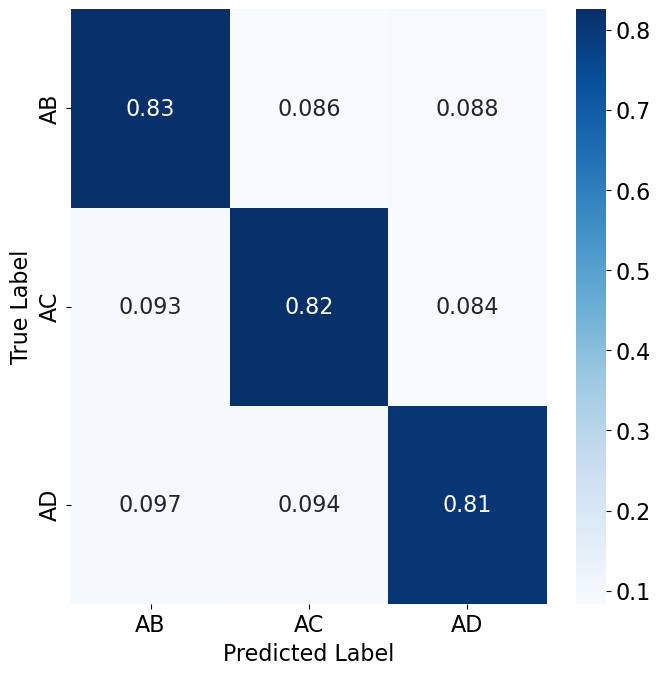

In [226]:
from sklearn.metrics import confusion_matrix

# extract label
y_true = df_iq_net_top['top']
y_pred = df_iq_net_top['pred_top']

# compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_percentage = cm.astype('float') / cm.sum(axis=1)

# labels
labels = ['AB', 'AC', 'AD']

# heat map
plt.figure(figsize=(7, 7))
sns.heatmap(cm_percentage, annot=True, cmap='Blues', xticklabels=labels, yticklabels=labels)


plt.title('')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')


plt.tight_layout(pad=1.0)
plt.savefig('heat_map.png',dpi=500,bbox_inches='tight')
plt.show()

In [ ]:
true_ext_branch = df_iqtree[['ext_b1','ext_b2','ext_b3','ext_b4']].to_numpy().flatten()
iq_tree_ext_branch = df_iqtree[['pred_a','pred_b','pred_c','pred_d']].to_numpy().flatten()
iq_net_ext_branch = df_quartet_net_bls[['pred_a','pred_b','pred_c','pred_d']].to_numpy().flatten()

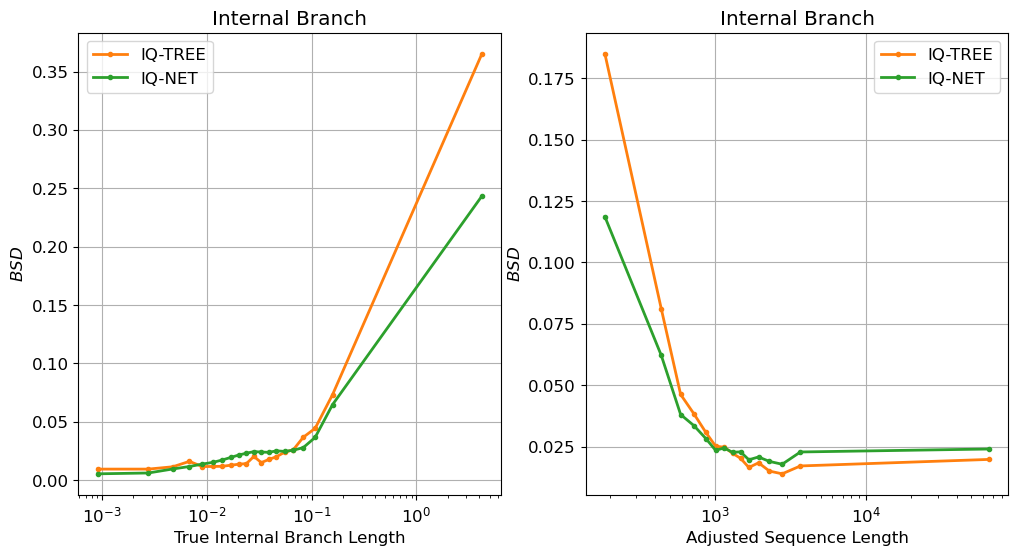

In [37]:
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = [8,8]
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 3


plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
_,bins = adaptive_histogram(df_iqtree.int_b,20)

methods = ['IQ-TREE','IQ-NET']

data =  np.abs(df_iqtree.bsd)
diff_by_bins = [ data[(df_iqtree.int_b >= bins[j]) & (df_iqtree.int_b < bins[j+1])] for j in range(len(bins)-1)]
means = np.array([v.mean() for v in diff_by_bins])
locs = [ (bins[i] + bins[i+1])/2 for i in range(len(bins)-1)]
plt.plot(locs, means, 'o-', label = methods[0],c=plt.cm.tab10(1))

_,bins = adaptive_histogram(df_test.int_b,20)

data =  np.abs(df_iq_net_bls.bsd)
diff_by_bins = [ data[(df_test.int_b >= bins[j]) & (df_test.int_b < bins[j+1])] for j in range(len(bins)-1)]
means = np.array([v.mean() for v in diff_by_bins])
locs = [ (bins[i] + bins[i+1])/2 for i in range(len(bins)-1)]
plt.plot(locs, means, 'o-', label = methods[1],c=plt.cm.tab10(2))

plt.xlabel('True Internal Branch Length') 
plt.ylabel('$BSD$')
plt.xscale('log')
# plt.yscale('log')
plt.legend()
plt.title('Internal Branch')
plt.grid()


plt.subplot(1,2,2)
_,bins = adaptive_histogram(df_iqtree.adapt_seq_length,15)

methods = ['IQ-TREE','IQ-NET']

data =  np.abs(df_iqtree.bsd)
diff_by_bins = [ data[(df_iqtree.adapt_seq_length >= bins[j]) & (df_iqtree.adapt_seq_length < bins[j+1])] for j in range(len(bins)-1)]
means = np.array([v.mean() for v in diff_by_bins])
locs = [ (bins[i] + bins[i+1])/2 for i in range(len(bins)-1)]
plt.plot(locs, means, 'o-', label = methods[0],c=plt.cm.tab10(1))

_,bins = adaptive_histogram(df_iq_net_bls.adapt_seq_length,15)

data =  np.abs(df_iq_net_bls.bsd)
diff_by_bins = [ data[(df_iq_net_bls.adapt_seq_length >= bins[j]) & (df_iq_net_bls.adapt_seq_length < bins[j+1])] for j in range(len(bins)-1)]
means = np.array([v.mean() for v in diff_by_bins])
locs = [ (bins[i] + bins[i+1])/2 for i in range(len(bins)-1)]
plt.plot(locs, means, 'o-', label = methods[1],c=plt.cm.tab10(2))

plt.xlabel('Adjusted Sequence Length') 
plt.ylabel('$BSD$')
plt.xscale('log')
# plt.yscale('log')
plt.legend()
plt.title('Internal Branch')
plt.grid()

plt.savefig('compare_bsd.png',dpi=500,bbox_inches='tight')

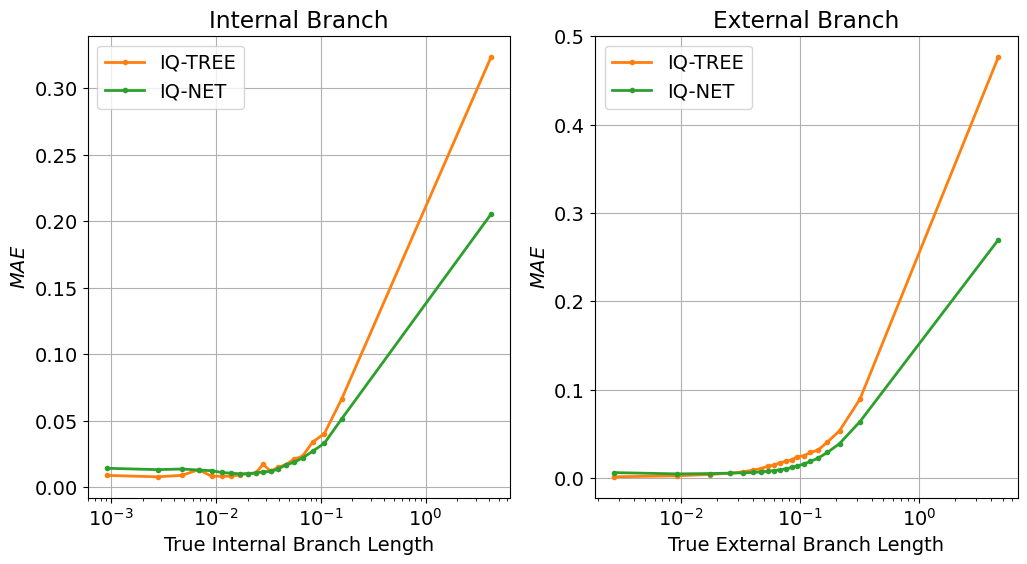

In [26]:
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = [8,8]
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 3


plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
_,bins = adaptive_histogram(df_iqtree.int_b,20)

methods = ['IQ-TREE','IQ-NET']

data =  np.abs(df_iqtree.int_b-df_iqtree.pred_int_b)
diff_by_bins = [ data[(df_iqtree.int_b >= bins[j]) & (df_iqtree.int_b < bins[j+1])] for j in range(len(bins)-1)]
means = np.array([v.mean() for v in diff_by_bins])
locs = [ (bins[i] + bins[i+1])/2 for i in range(len(bins)-1)]
plt.plot(locs, means, 'o-', label = methods[0],c=plt.cm.tab10(1))

_,bins = adaptive_histogram(df_test.int_b,20)

data =  np.abs(df_iq_net_bls.int_b-df_iq_net_bls.pred_int_b)
diff_by_bins = [ data[(df_test.int_b >= bins[j]) & (df_test.int_b < bins[j+1])] for j in range(len(bins)-1)]
means = np.array([v.mean() for v in diff_by_bins])
locs = [ (bins[i] + bins[i+1])/2 for i in range(len(bins)-1)]
plt.plot(locs, means, 'o-', label = methods[1],c=plt.cm.tab10(2))

plt.xlabel('True Internal Branch Length') 
plt.ylabel('$MAE$')
plt.xscale('log')
# plt.yscale('log')
plt.legend()
plt.title('Internal Branch')
plt.grid()


plt.subplot(1,2,2)
_,bins = adaptive_histogram(true_ext_branch,20)

methods = ['IQ-TREE','IQ-NET']

data =  np.abs(true_ext_branch-iq_tree_ext_branch)
diff_by_bins = [ data[(true_ext_branch >= bins[j]) & (true_ext_branch < bins[j+1])] for j in range(len(bins)-1)]
means = np.array([v.mean() for v in diff_by_bins])
locs = [ (bins[i] + bins[i+1])/2 for i in range(len(bins)-1)]
plt.plot(locs, means, 'o-', label = methods[0],c=plt.cm.tab10(1))

_,bins = adaptive_histogram(true_ext_branch,20)

data =  np.abs(true_ext_branch-iq_net_ext_branch)
diff_by_bins = [ data[(true_ext_branch >= bins[j]) & (true_ext_branch < bins[j+1])] for j in range(len(bins)-1)]
means = np.array([v.mean() for v in diff_by_bins])
locs = [ (bins[i] + bins[i+1])/2 for i in range(len(bins)-1)]
plt.plot(locs, means, 'o-', label = methods[1],c=plt.cm.tab10(2))

plt.xlabel('True External Branch Length') 
plt.ylabel('$MAE$')
plt.xscale('log')
# plt.yscale('log')
plt.legend()
plt.title('External Branch')
plt.grid()

plt.savefig('compare_val_int_mae_bl.png',dpi=500,bbox_inches='tight')

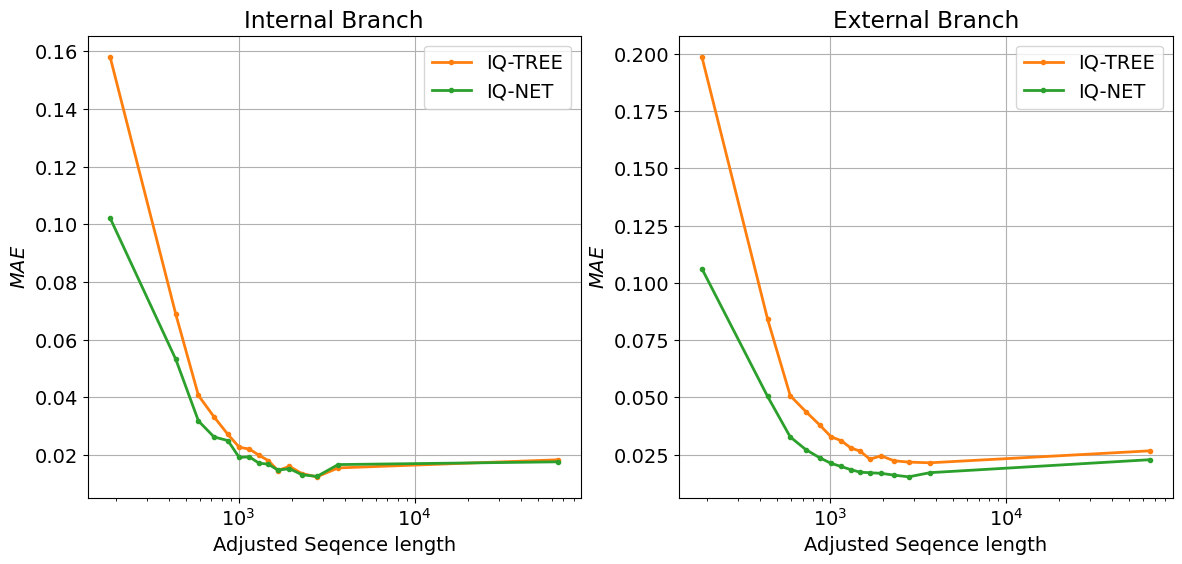

In [27]:
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = [8,8]
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 3

plt.figure(figsize=(14,6))

plt.subplot(1,2,1)


_,bins = adaptive_histogram(df_iqtree.adapt_seq_length,15)

methods = ['IQ-TREE','IQ-NET']

data =  np.abs(df_iqtree.int_b-df_iqtree.pred_int_b)
diff_by_bins = [ data[(df_iqtree.adapt_seq_length >= bins[j]) & (df_iqtree.adapt_seq_length < bins[j+1])] for j in range(len(bins)-1)]
means = np.array([v.mean() for v in diff_by_bins])
locs = [ (bins[i] + bins[i+1])/2 for i in range(len(bins)-1)]
plt.plot(locs, means, 'o-', label = methods[0],c=plt.cm.tab10(1))

_,bins = adaptive_histogram(df_iq_net_bls.adapt_seq_length,15)

data =  np.abs(df_iq_net_bls.int_b-df_iq_net_bls.pred_int_b)
diff_by_bins = [ data[(df_iq_net_bls.adapt_seq_length >= bins[j]) & (df_iq_net_bls.adapt_seq_length < bins[j+1])] for j in range(len(bins)-1)]
means = np.array([v.mean() for v in diff_by_bins])
locs = [ (bins[i] + bins[i+1])/2 for i in range(len(bins)-1)]
plt.plot(locs, means, 'o-', label = methods[1],c=plt.cm.tab10(2))

plt.xlabel('Adjusted Seqence length') 
plt.ylabel('$MAE$')
plt.xscale('log')
# plt.yscale('log')
plt.legend()
plt.title('Internal Branch')
plt.grid()


# array_1d = np.tile(df_iqtree['adapt_seq_length'].to_numpy(), 4)


plt.subplot(1,2,2)
_,bins = adaptive_histogram(df_iqtree.adapt_seq_length,15)

methods = ['IQ-TREE','IQ-NET']
true_list = ['ext_b1','ext_b2','ext_b3','ext_b4']
pred_list = ['pred_a','pred_b','pred_c','pred_d']
data =  np.abs(np.array(df_iqtree[true_list])-np.array(df_iqtree[pred_list]))
data = np.mean(data,axis =1)

diff_by_bins = [ data[(df_iqtree.adapt_seq_length >= bins[j]) & (df_iqtree.adapt_seq_length < bins[j+1])] for j in range(len(bins)-1)]

means = np.array([v.mean() for v in diff_by_bins])
locs = [ (bins[i] + bins[i+1])/2 for i in range(len(bins)-1)]
plt.plot(locs, means, 'o-', label = methods[0],c=plt.cm.tab10(1))

_,bins = adaptive_histogram(df_iqtree.adapt_seq_length,15)

data =  np.abs(np.array(df_iq_net_bls[true_list])-np.array(df_iq_net_bls[pred_list]))
data = np.mean(data,axis =1)
diff_by_bins = [ data[(df_iqtree.adapt_seq_length >= bins[j]) & (df_iqtree.adapt_seq_length < bins[j+1])] for j in range(len(bins)-1)]
means = np.array([v.mean() for v in diff_by_bins])
locs = [ (bins[i] + bins[i+1])/2 for i in range(len(bins)-1)]
plt.plot(locs, means, 'o-', label = methods[1],c=plt.cm.tab10(2))

plt.xlabel('Adjusted Seqence length') 
plt.ylabel('$MAE$')
plt.xscale('log')
# plt.yscale('log')
plt.legend()
plt.title('External Branch')
plt.grid()


plt.savefig('compare_val_int_mae_seq_l.png',dpi=500,bbox_inches='tight')

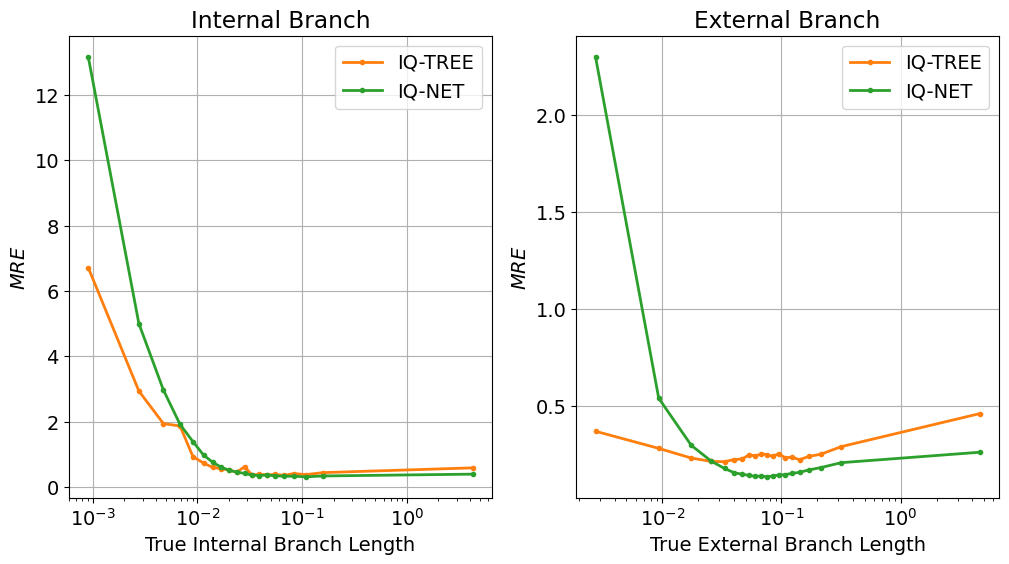

In [29]:

plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = [8,8]
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 3


plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
_,bins = adaptive_histogram(df_iqtree.int_b,20)

methods = ['IQ-TREE','IQ-NET']

data =  relative_difference(df_iqtree.int_b,df_iqtree.pred_int_b)
diff_by_bins = [ data[(df_iqtree.int_b >= bins[j]) & (df_iqtree.int_b < bins[j+1])] for j in range(len(bins)-1)]
means = np.array([v.mean() for v in diff_by_bins])
locs = [ (bins[i] + bins[i+1])/2 for i in range(len(bins)-1)]
plt.plot(locs, means, 'o-', label = methods[0],c=plt.cm.tab10(1))

_,bins = adaptive_histogram(df_test.int_b,20)

data =  relative_difference(df_iq_net_bls.int_b,df_iq_net_bls.pred_int_b)
diff_by_bins = [ data[(df_test.int_b >= bins[j]) & (df_test.int_b < bins[j+1])] for j in range(len(bins)-1)]
means = np.array([v.mean() for v in diff_by_bins])
locs = [ (bins[i] + bins[i+1])/2 for i in range(len(bins)-1)]
plt.plot(locs, means, 'o-', label = methods[1],c=plt.cm.tab10(2))

plt.xlabel('True Internal Branch Length') 
plt.ylabel('$MRE$')
plt.xscale('log')
# plt.yscale('log')
plt.legend()
plt.title('Internal Branch')
plt.grid()


plt.subplot(1,2,2)
_,bins = adaptive_histogram(true_ext_branch,20)

methods = ['IQ-TREE','IQ-NET']

data =  relative_difference(true_ext_branch,iq_tree_ext_branch)
diff_by_bins = [ data[(true_ext_branch >= bins[j]) & (true_ext_branch < bins[j+1])] for j in range(len(bins)-1)]
means = np.array([v.mean() for v in diff_by_bins])
locs = [ (bins[i] + bins[i+1])/2 for i in range(len(bins)-1)]
plt.plot(locs, means, 'o-', label = methods[0],c=plt.cm.tab10(1))

_,bins = adaptive_histogram(true_ext_branch,20)

data =  relative_difference(true_ext_branch,iq_net_ext_branch)
diff_by_bins = [ data[(true_ext_branch >= bins[j]) & (true_ext_branch < bins[j+1])] for j in range(len(bins)-1)]
means = np.array([v.mean() for v in diff_by_bins])
locs = [ (bins[i] + bins[i+1])/2 for i in range(len(bins)-1)]
plt.plot(locs, means, 'o-', label = methods[1],c=plt.cm.tab10(2))

plt.xlabel('True External Branch Length') 
plt.ylabel('$MRE$')
plt.xscale('log')
# plt.yscale('log')
plt.legend()
plt.title('External Branch')
plt.grid()

plt.savefig('compare_val_int_mre_bl.png',dpi=500,bbox_inches='tight')

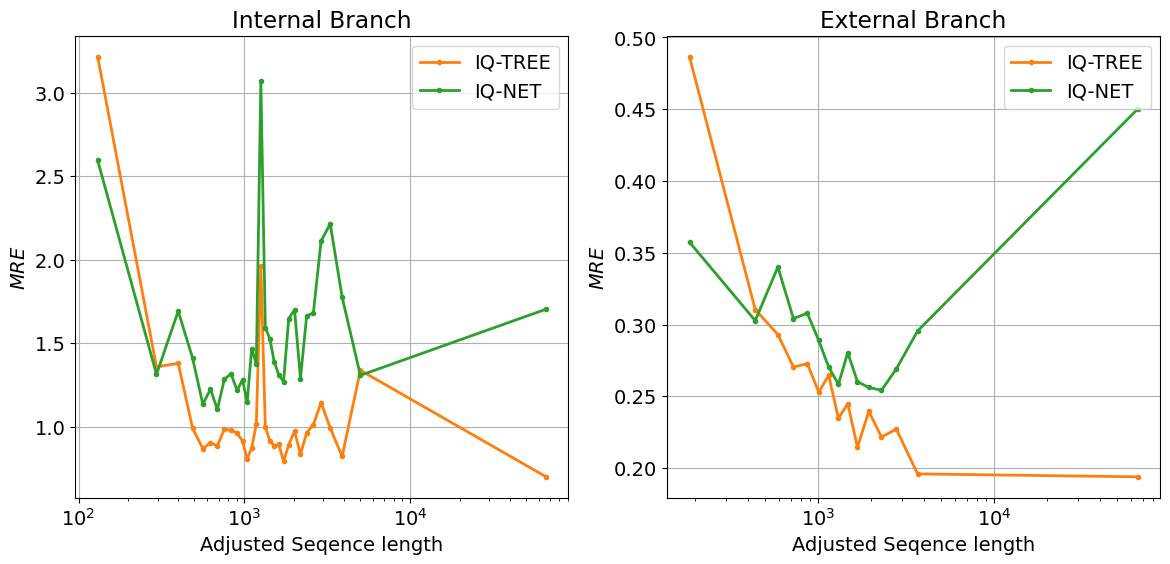

In [28]:
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = [8,8]
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 3

plt.figure(figsize=(14,6))

plt.subplot(1,2,1)


_,bins = adaptive_histogram(df_iqtree.adapt_seq_length,30)

methods = ['IQ-TREE','IQ-NET']

data =  relative_difference(df_iqtree.int_b,df_iqtree.pred_int_b)
diff_by_bins = [ data[(df_iqtree.adapt_seq_length >= bins[j]) & (df_iqtree.adapt_seq_length < bins[j+1])] for j in range(len(bins)-1)]
means = np.array([v.mean() for v in diff_by_bins])
locs = [ (bins[i] + bins[i+1])/2 for i in range(len(bins)-1)]
plt.plot(locs, means, 'o-', label = methods[0],c=plt.cm.tab10(1))

_,bins = adaptive_histogram(df_iq_net_bls.adapt_seq_length,30)

data =  relative_difference(df_iq_net_bls.int_b,df_iq_net_bls.pred_int_b)
diff_by_bins = [ data[(df_iq_net_bls.adapt_seq_length >= bins[j]) & (df_iq_net_bls.adapt_seq_length < bins[j+1])] for j in range(len(bins)-1)]
means = np.array([v.mean() for v in diff_by_bins])
locs = [ (bins[i] + bins[i+1])/2 for i in range(len(bins)-1)]
plt.plot(locs, means, 'o-', label = methods[1],c=plt.cm.tab10(2))

plt.xlabel('Adjusted Seqence length') 
plt.ylabel('$MRE$')
plt.xscale('log')
# plt.yscale('log')
plt.legend()
plt.title('Internal Branch')
plt.grid()


# array_1d = np.tile(df_iqtree['adapt_seq_length'].to_numpy(), 4)


plt.subplot(1,2,2)
_,bins = adaptive_histogram(df_iqtree.adapt_seq_length,15)

methods = ['IQ-TREE','IQ-NET']
true_list = ['ext_b1','ext_b2','ext_b3','ext_b4']
pred_list = ['pred_a','pred_b','pred_c','pred_d']
# data =  np.abs(np.array(df_iqtree[true_list])-np.array(df_iqtree[pred_list]))/(np.array(df_iqtree[true_list])+1e-8)
data = relative_difference(np.array(df_iqtree[true_list]),np.array(df_iqtree[pred_list]))
data = np.mean(data,axis =1)

diff_by_bins = [ data[(df_iqtree.adapt_seq_length >= bins[j]) & (df_iqtree.adapt_seq_length < bins[j+1])] for j in range(len(bins)-1)]

means = np.array([v.mean() for v in diff_by_bins])
locs = [ (bins[i] + bins[i+1])/2 for i in range(len(bins)-1)]
plt.plot(locs, means, 'o-', label = methods[0],c=plt.cm.tab10(1))

_,bins = adaptive_histogram(df_iqtree.adapt_seq_length,15)

# data =  np.abs(np.array(df_quartet_net_bls[true_list])-np.array(df_quartet_net_bls[pred_list]))/(np.array(df_iqtree[true_list])+1e-8)
data = relative_difference(np.array(df_iq_net_bls[true_list]),np.array(df_iq_net_bls[pred_list]))
data = np.mean(data,axis =1)
diff_by_bins = [ data[(df_iqtree.adapt_seq_length >= bins[j]) & (df_iqtree.adapt_seq_length < bins[j+1])] for j in range(len(bins)-1)]
means = np.array([v.mean() for v in diff_by_bins])
locs = [ (bins[i] + bins[i+1])/2 for i in range(len(bins)-1)]
plt.plot(locs, means, 'o-', label = methods[1],c=plt.cm.tab10(2))

plt.xlabel('Adjusted Seqence length') 
plt.ylabel('$MRE$')
plt.xscale('log')
# plt.yscale('log')
plt.legend()
plt.title('External Branch')
plt.grid()


plt.savefig('compare_val_int_mre_seq_l.png',dpi=500,bbox_inches='tight')